# Question in hand

We created a function that numerically integrates homologous outflow diff, eq's from radius $r_o = r(t_0)$ to $r_f = r(t_f)$. The function is not fully set up to take advantage of NumPy's capabilities.

We will try to optimize it for NumPy.

# 0. Importing Libraries and Defining Necessary Functions

We first import necessary libraries.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as unit
import astropy.constants as const
from matplotlib.patches import Rectangle
import time
%matplotlib notebook

In order to have initial conditions for the solver, we will use a spherical outflow cell grid. We define the spherical outflow function below.

In [2]:
def make_spherical_outflow( x, y, luminosity, gamma_infinity, r_0):
    r = np.sqrt(x**2+y**2)
    gg=np.zeros(r.shape)
    pp=np.zeros(r.shape)
    
    jj = np.where(r < (r_0 * gamma_infinity))
    kk = np.where(r >= (r_0 * gamma_infinity))

    if len(jj) > 0: 
        gg[jj] = r[jj] / r_0
    gg[kk] = gamma_infinity

    dd = (luminosity / 4 / np.pi / r ** 2 / const.c.cgs.value ** 3 / 
      gg / gamma_infinity)

    if jj[0].size > 0:
        pp[jj] = luminosity / 12 / np.pi / const.c.cgs.value * r_0 ** 2 / r[jj] ** 4
    pp[kk] = (luminosity / 12. / np.pi / const.c.cgs.value * 
      r_0 ** (2. / 3.) / gamma_infinity ** (4. / 3.) * (
      r[kk] ** ( -8. / 3.) ) )
    ee = 3 * pp
    return ee, gg, dd

# 1. Defining Homologous Outflow Solver

We now define the functions needed for the solver.

We first define the radius step size as a function of time. We do so by using Ore's approximation shown in Sec 3.2 in his paper (https://arxiv.org/pdf/1904.07244.pdf). 

We want each cell to propagate using the following equation:

$$r(t_f) = r(t_0 ) + ( t_f - t_0 )\cdot c \cdot\hat{\Omega}$$

where $\hat{\Omega} = \frac{\dot{r}}{|\dot{r}|}$ and $c$ is the speed of light.

Once the new radius is calculated, we can use this new radius to use as the endpoint of our homologous outflow solver.

In [3]:
def omega(v):
    '''
    Return $\hat{\Omega} = \dot{r}/|\dot{r}|$ in 2D. 
    This quantity is the unit first time derivative of the radius vector.
    
    INPUT: 
    
    --v (numpy array): 2D vector containing x,y components of 
    velocity vector.
    
    OUTPUT: 
    
    --omega (numpy array): 2D vector containing x,y components of 
    velocity unit vector.
    '''
    return ( v / np.linalg.norm( v ) )

def s(t_sim, t):
    '''
    Return $s = c (t-t_{sim})$ in 2D. 
    This quantity is the step size the cell takes when moving at 
    speed $c$ from time $t_{sim}$ to time $t$. 
    
    INPUT: 
    
    --t_sim (float): initial time
    
    --t (float): final time
    
    --v (float): speed
    
    OUTPUT: 
    
    --s float: magnitude of step taken in time $(t-t_{sim}})$ given by velocity $c$.
    '''

    return ( ( t - t_sim ) * const.c.cgs.value )

def r_step_c(r_i,s,omega_hat):
    '''
    Return $r = r_i + s \hat{\Omega}$ in 2D. 
    This quantity is the step size the cell takes when moving a distance
    given by s from time $t_{sim}$ to time $t$
    
    INPUT: 
    
    --r_i (numpy array)
    
    --t_sim (float): initial time
    
    --t (float): final time
    
    OUTPUT: 
    
    --s float: magnitude of step taken in time $(t-t_{sim}})$
    '''
    return ( r_i + s*omega_hat )

def dedr(e,gamma,n,r):
    return  -(8*(e**(3/4))*(4*e + 3*n))/(r*((9*n/(e**(1/4)) + 8*(e**(3/4))))) 

def dgammadr(e,gamma,n,r):
    return (8*(e**(3/4))*gamma)/(r*((9*n/(e**(1/4)) + 8*(e**(3/4)))))

def dndr(e,gamma,n,r):
    return -(6*n*(4*e + 3*n))/(e**(1/4)*r*((9*n/(e**(1/4)) + 8*(e**(3/4)))))

def homologous_outflow( gam, dens, r0, rf, ener = None, h_i = None):
    '''
    Return the solution to ODE soln. vectors (r, energy, gamma, density) 
    from r0 to rf.
    Integrates set of homologous outflow equations with initial conditions 
    
    ener (erg cm^-3 c^-2 = g cm^-3 energy density over c^2), 
    
    gam (unitless Lorentz factor), 
    
    n (g cm^-3 mass density),
    
    from r0 to rf (cm).
    
    INPUT: 
    
    --gam (float): initial Lorentz Factor
    
    --dens (float): initial mass density
    
    --r0 (float): initial radius
    
    --rf (float): final radius
    
    --ener (float): initial energy/$c^2$, default = None
    
    --h_i (float): initial specific enthalpy, default = None
    
    OUTPUT: 
    
    --r_step (numpy array): vector containing radius discretization for solution vectors
    
    --e_arr (numpy array): vector containing solution for energy/$c^2$ as a function of radius
    
    --gamma_arr (numpy array): vector containing solution for Lorentz factor as a function of radius
    
    --n_arr (numpy array): vector containing solution for mass density as a function of radius
    
    --h_arr (numpy array): vector containing solution for specific enthalpy as a function of radius
    
    NOTES:
    
    --Even though the parameter defaults for ener and h_i are None, the function needs one or the other
    in order to retrieve the solution vectors. if ener is given, it will take it as ICs. If h_i is given,
    the function calculates energy from this and proceeds to solve the ODEs with this calculated IC.
    '''
    
    if ener == None:    
        ener = 3*(h_i-1)*dens/4 

    
    e_start = ener #e_tilde #e/const.c.cgs.value**2
    gamma_start = gam
    n_start = dens #/const.m_p.cgs.value

    
    r_step = 10**np.arange(np.log10(r0),np.log10(rf),1e-3)

    
    e_arr = np.zeros(len(r_step))       # create an array of zeros for e
    gamma_arr = np.zeros(len(r_step))   # create an array of zeros for gamma
    n_arr = np.zeros(len(r_step))       # create an array of zeros for n
    e_arr[0] = e_start                  # add initial value of e to array
    gamma_arr[0] = gamma_start          # add initial value of gamma to array
    n_arr[0] = n_start                  # add initial value of n to array

    for i in range (1, len(r_step)):  
        e = e_arr[i-1]
        gamma = gamma_arr[i-1]
        n = n_arr[i-1]
        r = r_step[i-1]
        Dr = r_step[i] - r_step[i-1]

        #calculate k1 for e, gamma and n
        k1_e = dedr(e,gamma,n,r)
        k1_gamma = dgammadr(e,gamma,n,r)
        k1_n = dndr(e,gamma,n,r)

        #calculate k2 for e, gamma and n
        k2_e = dedr(e+(1/2)*Dr*k1_e,gamma+(1/2)*Dr*k1_gamma,n+(1/2)*Dr*k1_n,r+(1/2)*Dr)
        k2_gamma = dgammadr(e+(1/2)*Dr*k1_e,gamma+(1/2)*Dr*k1_gamma,n+(1/2)*Dr*k1_n,r+(1/2)*Dr)
        k2_n = dndr(e+(1/2)*Dr*k1_e,gamma+(1/2)*Dr*k1_gamma,n+(1/2)*Dr*k1_n,r+(1/2)*Dr)

        #calculate k3 for e, gamma and n
        k3_e = dedr(e+(1/2)*Dr*k2_e,gamma+(1/2)*Dr*k2_gamma,n+(1/2)*Dr*k2_n,r+(1/2)*Dr)
        k3_gamma = dgammadr(e+(1/2)*Dr*k2_e,gamma+(1/2)*Dr*k2_gamma,n+(1/2)*Dr*k2_n,r+(1/2)*Dr)
        k3_n = dndr(e+(1/2)*Dr*k2_e,gamma+(1/2)*Dr*k2_gamma,n+(1/2)*Dr*k2_n,r+(1/2)*Dr)

        #calculate k4 for e, gamma and n
        k4_e = dedr(e+Dr*k3_e,gamma+Dr*k3_gamma,n+Dr*k3_n,r+Dr)
        k4_gamma = dgammadr(e+Dr*k3_e,gamma+Dr*k3_gamma,n+Dr*k3_n,r+Dr)
        k4_n = dndr(e+Dr*k3_e,gamma+Dr*k3_gamma,n+Dr*k3_n,r+Dr)

        e_arr[i] = e + (1/6)*Dr*(k1_e+2*k2_e+2*k3_e+k4_e)                   # calc. e at next radius step,add to array
        gamma_arr[i] = gamma + (1/6)*Dr*(k1_gamma+2*k2_gamma+2*k3_gamma+k4_gamma) # calc. gamma at next radius step,add to array
        n_arr[i] = n + (1/6)*Dr*(k1_n+2*k2_n+2*k3_n+k4_n)           # calc. n at next radius tep,add to array
        
    h_arr = 1+ (4*e_arr)/(3*n_arr)
    
    return (r_step, e_arr, gamma_arr, n_arr, h_arr)

# 2. Example of solver use

We now use an example on how this solver works and how it's used.

We first start by setting our initial conditions from a spherical outflow grid. 

We will set up a cell grid that's located along the y-axis (jet axis). Since we will adapt this to an HD frame later, we need the border of the cell column closest to the axis to be at x = 0 instead of the cell coordinate itself, so there is no part of the cell in the negative x-axis. 

We want the cell size to be $10^9$ cm at a radius of $\sim10^{12}$ cm, to better replicate the AMR grid that we would encounter at the end of an HD GRB simulation, where we expect to have reached a homologous outflow.

We will populate the grid with spherical outflow properties. We set our parameters to be $L_{iso} = 10^{54}$ erg s$^{-1}$, $\Gamma_{\infty}=100$, $r_0 = 10^{11}$ cm.

In [4]:
cell_size = 1e9

nx_jet_axis, ny_jet_axis = (101, 101) #number of steps
x_jet_axis = np.linspace(cell_size/2, cell_size/2 + 0.1e12, nx_jet_axis) #create x-interval of size 1e11
y_jet_axis = np.linspace(1e12, 1.1e12, ny_jet_axis) #create y-interval of size 1e11
xv_jet_axis, yv_jet_axis = np.meshgrid(x_jet_axis, y_jet_axis) #create 2D grid with x and y values

r0_jet_axis = np.sqrt(xv_jet_axis**2 + yv_jet_axis**2)

energy_jet_axis, gamma_jet_axis, density_jet_axis = make_spherical_outflow(
  xv_jet_axis, yv_jet_axis, 1e54, 100, 1e11)

energy_jet_axis = energy_jet_axis/const.c.cgs.value**2

h_i_jet_axis = 1+ (4*energy_jet_axis)/(3*density_jet_axis)

With our initial conditions set up, we can now scatter this grid for $\Delta t = 100$ s. Doing this with the way the function is set up requires long for loops, making it very inefficient.

In [5]:
start = time.time()

delta_t = 110

new_radius_jet_axis_c = np.zeros(r0_jet_axis.shape)

theta_grid = np.arctan(xv_jet_axis/yv_jet_axis)

x_comps_jet_axis_c = np.zeros(xv_jet_axis.shape)

y_comps_jet_axis_c = np.zeros(yv_jet_axis.shape)

gam = np.zeros(gamma_jet_axis.shape)

ener = np.zeros(energy_jet_axis.shape)

dens = np.zeros(density_jet_axis.shape)

h = np.zeros(h_i_jet_axis.shape)

for i in range(len(r0_jet_axis)):

    for j in range(len(r0_jet_axis[i])):

        gamma = gamma_jet_axis[i][j]

        density = density_jet_axis[i][j]

        r_0 = r0_jet_axis[i][j]

        s_t = s(10,delta_t)

        omega_hat = omega(np.asarray([
          xv_jet_axis[i][j],yv_jet_axis[i][j]]))

        r_step = r_step_c(np.array([xv_jet_axis[i][j], 
          yv_jet_axis[i][j]]), s_t, omega_hat)

        r_f = np.linalg.norm(r_step)

        x_comps_jet_axis_c[i,j] = r_f*np.sin(theta_grid[i][j])

        y_comps_jet_axis_c[i,j] = r_f*np.cos(theta_grid[i][j])

        new_radius_jet_axis_c[i,j] = r_f

        r, e, g, n, enth = homologous_outflow(
          gamma_jet_axis[i,j], 
          density_jet_axis[i,j], 
          r0_jet_axis[i,j], 
          new_radius_jet_axis_c[i,j], 
          h_i = h_i_jet_axis[i,j])

        ener[i,j] = e[-1]

        gam[i,j] = g[-1]

        dens[i,j] = n[-1]

        h[i,j] = enth[-1]
        
end = time.time()

print(end - start)

138.45179224014282


We now plot the initial Lorentz factor in each cell in the grid.

The solver takes about 2.25 minutes (2:15) to run for delta_t = 100.

<IPython.core.display.Javascript object>


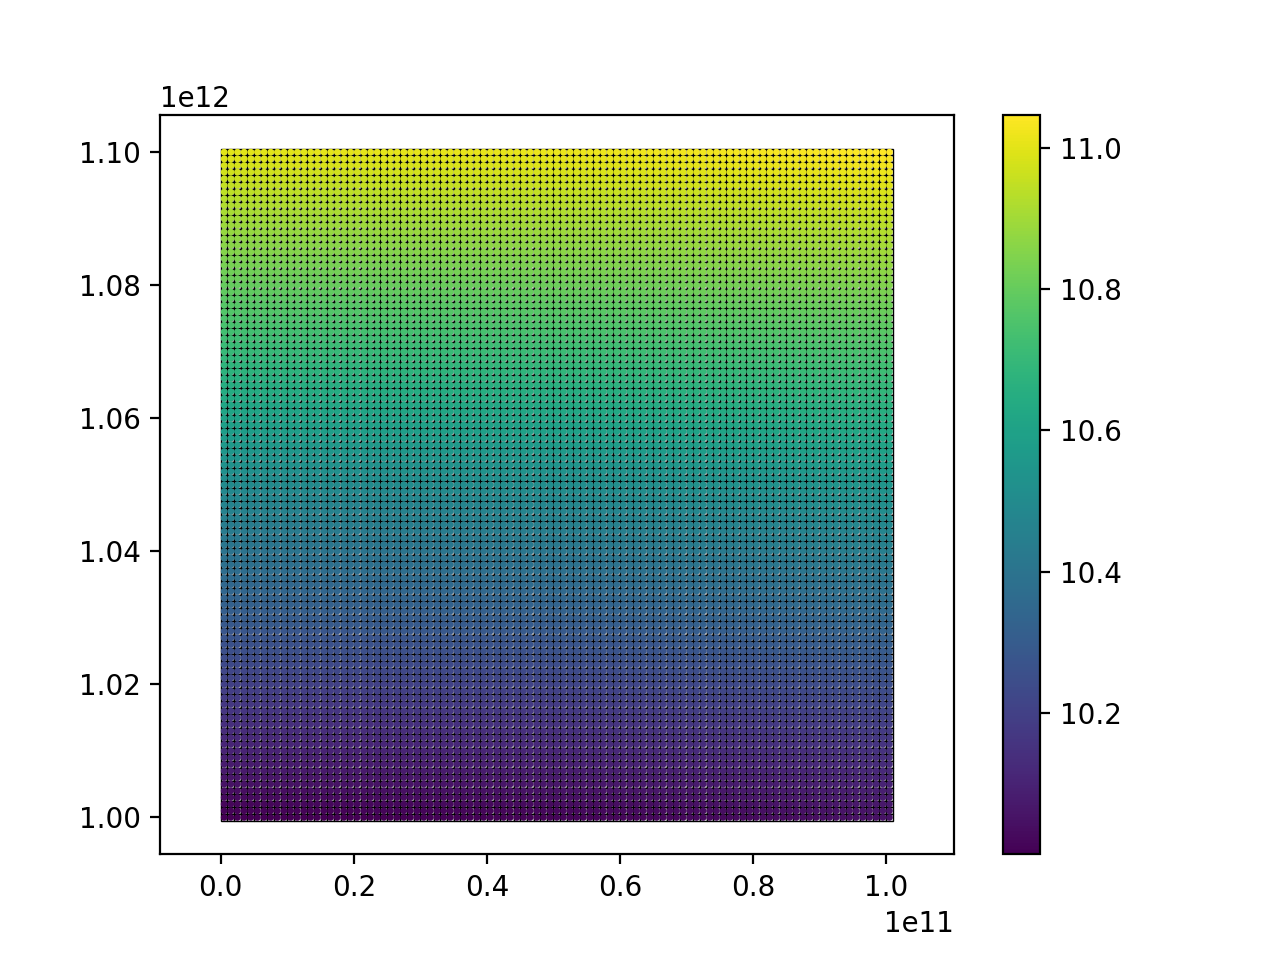

In [6]:
fig = plt.figure()

ax = plt.gca()

for i in range(len(xv_jet_axis)):
    
    for j in range(len(xv_jet_axis[0])):

        ax.add_patch(Rectangle((xv_jet_axis[i][j]-cell_size/2, 
          yv_jet_axis[i][j]-cell_size/2), cell_size,
          cell_size, facecolor="none", ec='k', lw=0.5))

mapp1 = ax.scatter(xv_jet_axis,yv_jet_axis, c = gamma_jet_axis, s = 2)

cb1 = plt.colorbar(mappable = mapp1, ax = ax)

plt.axis('equal')

plt.show()

We now plot the final Lorentz factor in each cell in the grid. The grid now has new coordinates and shape.

<IPython.core.display.Javascript object>


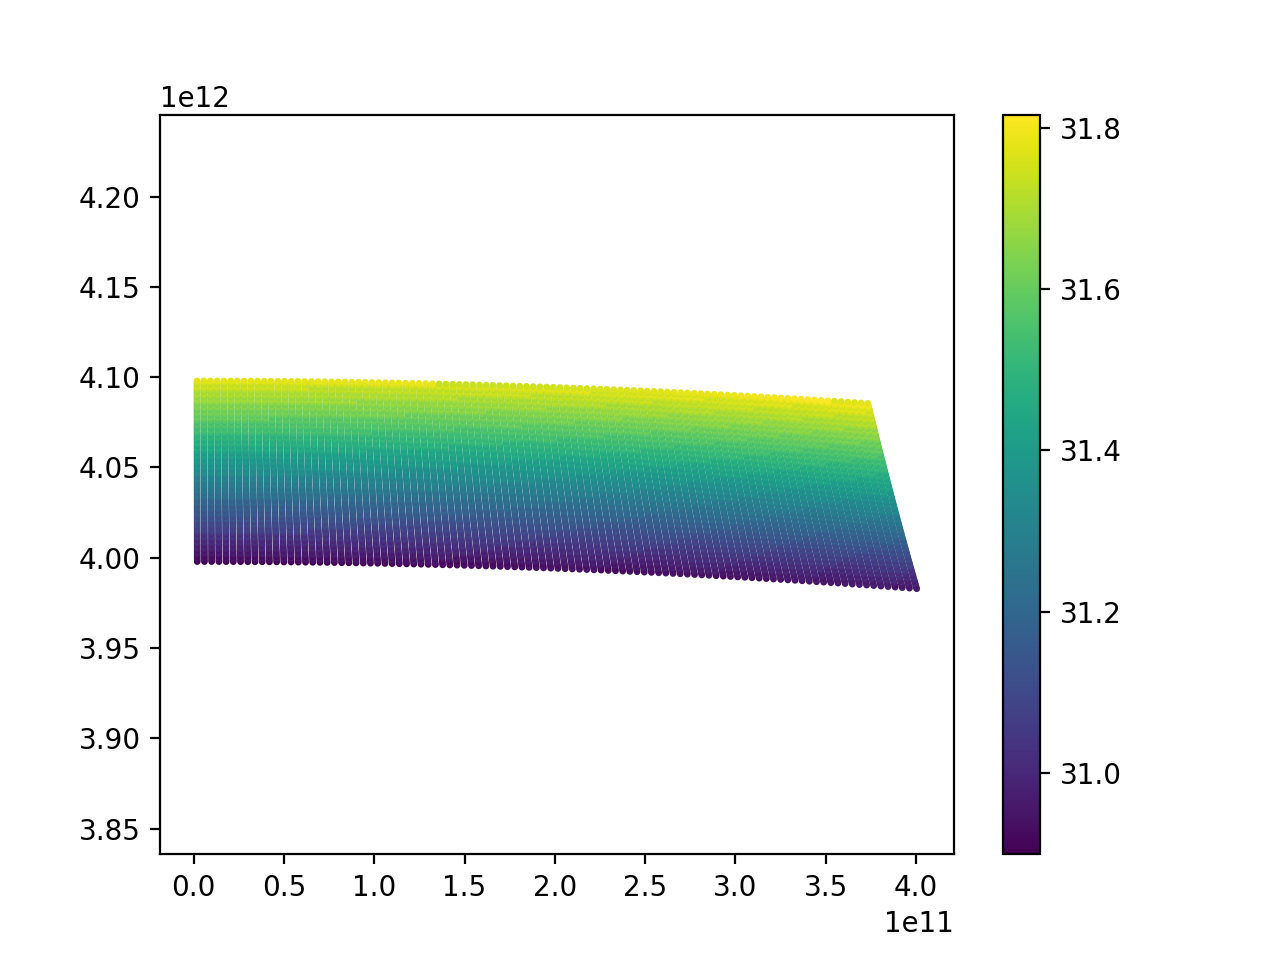

In [7]:
fig = plt.figure()

ax = plt.gca()

for i in range(len(xv_jet_axis)):
    
    for j in range(len(xv_jet_axis[0])):

        ax.add_patch(Rectangle((x_comps_jet_axis_c[i][j]-cell_size/2, 
          y_comps_jet_axis_c[i][j]-cell_size/2), 
          cell_size,cell_size, facecolor="none", ec='k', lw=0.5))

mapp1 = ax.scatter(x_comps_jet_axis_c,y_comps_jet_axis_c, c = gam, s = 2)

cb1 = plt.colorbar(mappable = mapp1, ax = ax)

plt.axis('equal')

plt.show()

# 3. Optimizing the solver for NumPy

We now will work on optimizing each function to run the calculations taking advantage of NumPy arrays.

First, omega will be changed. There is an assumption that the grid only has two dimensions.

In [8]:
def omega_numpy(v):
    '''
    Return $\hat{\Omega} = \dot{r}/|\dot{r}|$ for a cell grid. 
    This quantity is the unit first time derivative of the radius vector.
    
    INPUT: 
    
    --v (numpy array): (n, n, 2) shaped array containing x,y components of 
    velocity vector for an n by n grid.
    
    OUTPUT: 
    
    --omega (numpy array): (n, n, 2) vector containing x,y components of 
    velocity unit vector for an n by n grid.
    '''
    return v / np.linalg.norm(v, axis = 2)[:,:,None]

Now, we can populate a matrix containing the x,y components of velocity given by the Lorentz factor and posisition (will use velocity vector when considering an HD frame) of each cell.

In [9]:
v_gamma = np.sqrt(1-1/gamma_jet_axis**2)*const.c.cgs.value

velo = np.zeros((gamma_jet_axis.shape[0],gamma_jet_axis.shape[1],2))

for i in range(gamma_jet_axis.shape[0]):
    for j in range(gamma_jet_axis.shape[0]):
        velo[i][j] = v_gamma[i][j]*np.asarray([xv_jet_axis[i][j],yv_jet_axis[i][j]])/r0_jet_axis[i][j]
        
omega_numpy(velo)

array([[[4.99999938e-04, 9.99999875e-01],
        [1.49999831e-03, 9.99998875e-01],
        [2.49999219e-03, 9.99996875e-01],
        ...,
        [9.80256134e-02, 9.95183892e-01],
        [9.90110898e-02, 9.95086330e-01],
        [9.99962751e-02, 9.94987811e-01]],

       [[4.99500437e-04, 9.99999875e-01],
        [1.49849982e-03, 9.99998877e-01],
        [2.49749471e-03, 9.99996881e-01],
        ...,
        [9.79286253e-02, 9.95193441e-01],
        [9.89131459e-02, 9.95096071e-01],
        [9.98973761e-02, 9.94997746e-01]],

       [[4.99001934e-04, 9.99999875e-01],
        [1.49700431e-03, 9.99998879e-01],
        [2.49500221e-03, 9.99996887e-01],
        ...,
        [9.78318280e-02, 9.95202961e-01],
        [9.88153945e-02, 9.95105782e-01],
        [9.97986716e-02, 9.95007651e-01]],

       ...,

       [[4.55373359e-04, 9.99999896e-01],
        [1.36611894e-03, 9.99999067e-01],
        [2.27686113e-03, 9.99997408e-01],
        ...,
        [8.93497548e-02, 9.96000312e-01],
     

Since the s function is not dependent on the grid, this one can stay the same.

The r_step_c function is dependent on grid cell position. This one also needs to be optimized for NumPy. This function can stay the same. 

In [10]:
def r_step_c_numpy(r_i,s,omega_hat):
    '''
    Return $r = r_i + s \hat{\Omega}$ in 2D. 
    This quantity is the step size the cell takes when moving a distance
    given by s from time $t_{sim}$ to time $t$
    
    INPUT: 
    
    --r_i (numpy array)
    
    --t_sim (float): initial time
    
    --t (float): final time
    
    OUTPUT: 
    
    --s float: magnitude of step taken in time $(t-t_{sim}})$
    '''
    return ( r_i + s * omega_hat )

In [11]:
r_comps = np.zeros((r0_jet_axis.shape[0],r0_jet_axis.shape[1],2))

for i in range(r0_jet_axis.shape[0]):
    for j in range(r0_jet_axis.shape[0]):
        r_comps[i][j] = np.asarray([xv_jet_axis[i][j],yv_jet_axis[i][j]])

In [12]:
new_r = r_step_c_numpy(r_comps, s(10,delta_t), omega_numpy(velo))

new_r.shape

(101, 101, 2)

<IPython.core.display.Javascript object>


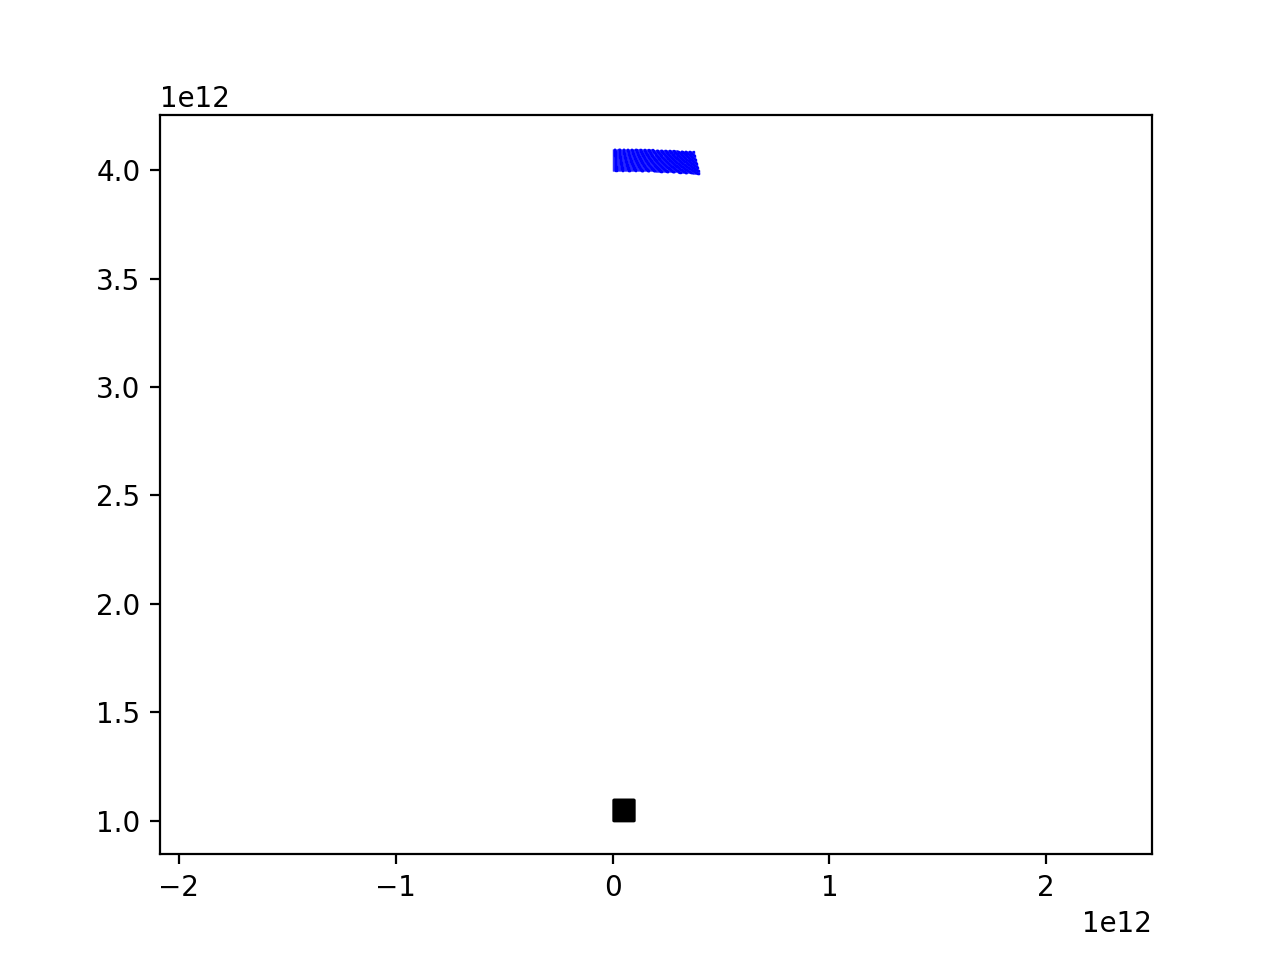

In [13]:
fig = plt.figure()

ax = plt.gca()

for i in range(len(xv_jet_axis)):
    
    for j in range(len(xv_jet_axis[0])):

        ax.add_patch(Rectangle((r_comps[i][j][0]-cell_size/2, 
          r_comps[i][j][1]-cell_size/2), 
          cell_size,cell_size, facecolor="none", ec='k', lw=0.5))
        
        ax.add_patch(Rectangle((new_r[i][j][0]-cell_size/2, 
          new_r[i][j][1]-cell_size/2), 
          cell_size,cell_size, facecolor="none", ec='blue', lw=0.5))

#mapp1 = ax.scatter(x_comps_jet_axis_c,y_comps_jet_axis_c)

plt.axis('equal')

plt.show()

Now we need to optimize the actual RK4 solver to read in numpy arrays.

# 3.5 Updating the solver

The folowing method is used:

Using the np.linalg.norm function, we are able to have a matrix containing the radius magnitude after the expansion happens. 

In [15]:
rf_jet_axis = np.linalg.norm(new_r, axis = 2)

print(rf_jet_axis)
print(rf_jet_axis.shape)

[[3.99792470e+12 3.99792570e+12 3.99792770e+12 ... 4.00276400e+12
  4.00286251e+12 4.00296202e+12]
 [3.99892470e+12 3.99892570e+12 3.99892770e+12 ... 4.00375918e+12
  4.00385760e+12 4.00395701e+12]
 [3.99992470e+12 3.99992570e+12 3.99992770e+12 ... 4.00475438e+12
  4.00485271e+12 4.00495201e+12]
 ...
 [4.09592469e+12 4.09592560e+12 4.09592743e+12 ... 4.10033387e+12
  4.10042367e+12 4.10051437e+12]
 [4.09692469e+12 4.09692560e+12 4.09692742e+12 ... 4.10132988e+12
  4.10141960e+12 4.10151021e+12]
 [4.09792469e+12 4.09792560e+12 4.09792742e+12 ... 4.10232589e+12
  4.10241553e+12 4.10250606e+12]]
(101, 101)


The spacing of each cell in the rf matrix and the r0 matrix is the same for all cells. This makes sense since they all scattered at the same speed ($c$) for the same amount of time.

In [16]:
rf_jet_axis - r0_jet_axis

array([[2.99792458e+12, 2.99792458e+12, 2.99792458e+12, ...,
        2.99792458e+12, 2.99792458e+12, 2.99792458e+12],
       [2.99792458e+12, 2.99792458e+12, 2.99792458e+12, ...,
        2.99792458e+12, 2.99792458e+12, 2.99792458e+12],
       [2.99792458e+12, 2.99792458e+12, 2.99792458e+12, ...,
        2.99792458e+12, 2.99792458e+12, 2.99792458e+12],
       ...,
       [2.99792458e+12, 2.99792458e+12, 2.99792458e+12, ...,
        2.99792458e+12, 2.99792458e+12, 2.99792458e+12],
       [2.99792458e+12, 2.99792458e+12, 2.99792458e+12, ...,
        2.99792458e+12, 2.99792458e+12, 2.99792458e+12],
       [2.99792458e+12, 2.99792458e+12, 2.99792458e+12, ...,
        2.99792458e+12, 2.99792458e+12, 2.99792458e+12]])

The definitions for the diff. eq.n's stay the same, but the solver changes. The first detail was to discretize the radius differently. I had been doing a log scale for the step size, but I stuck with equally sized steps to make it easier to type up.

In [17]:
def homologous_outflow_numpy( gam, dens, r0, rf, ener = None, h_i = None):
    '''
    Return the solution to ODE soln. vectors (r, energy, gamma, density) 
    from r0 to rf.
    Integrates set of homologous outflow equations with initial conditions 
    
    ener (erg cm^-3 c^-2 = g cm^-3 energy density over c^2), 
    
    gam (unitless Lorentz factor), 
    
    n (g cm^-3 mass density),
    
    from r0 to rf (cm).
    
    INPUT: 
    
    --gam (numpy array): matrix containing a grid for initial Lorentz Factor
    
    --dens (numpy array): matrix containing a grid for initial mass density
    
    --r0 (numpy array): matrix containing a grid for initial radius
    
    --rf (numpy array): matrix containing a grid for final radius
    
    --ener (numpy array): matrix containing a grid for initial energy/$c^2$, default = None
    
    --h_i (numpy array): matrix containing a grid for initial specific enthalpy, default = None
    
    OUTPUT: 
    
    --r_step (numpy array): matrix containing a grid with vectors 
    containing radius discretization for solution vectors
    
    --e_arr (numpy array): matrix containing a grid with vectors 
    containing solution for energy/$c^2$ as a function of radius
    
    --gamma_arr (numpy array): matrix containing a grid with vectors 
    containing solution for Lorentz factor as a function of radius
    
    --n_arr (numpy array): matrix containing a grid with vectors 
    containing solution for mass density as a function of radius
    
    --h_arr (numpy array): matrix containing a grid with vectors 
    containing solution for specific enthalpy as a function of radius
    
    NOTES:
    
    --Even though the parameter defaults for ener and h_i are None, the function needs one or the other
    in order to retrieve the solution vectors. if ener is given, it will take it as ICs. If h_i is given,
    the function calculates energy from this and proceeds to solve the ODEs with this calculated IC.
    '''
    
    if ener == None: 
        
        ener = 3 * ( h_i - 1 ) * dens / 4 
    
    e_start = ener #e_tilde #e/const.c.cgs.value**2
    gamma_start = gam
    n_start = dens #/const.m_p.cgs.value

    
    
    steps = 10000

    diff = (rf - r0)/(steps-1)

    r_step = np.zeros((steps, r0.shape[0], r0.shape[1]))

    r_step[0] = r0

    for i in range(1, steps):
    
        r_step[i] = r_step[i-1] + diff

    
    
    e_arr = np.zeros(r_step.shape)       # create an array of zeros for e
    gamma_arr = np.zeros(r_step.shape)   # create an array of zeros for gamma
    n_arr = np.zeros(r_step.shape)       # create an array of zeros for n
    h_arr = np.zeros(r_step.shape)
    e_arr[0] = e_start                  # add initial value of e to array
    gamma_arr[0] = gamma_start          # add initial value of gamma to array
    n_arr[0] = n_start                  # add initial value of n to array
    h_arr[0] = h_i

    for i in range (1, r_step.shape[0]):  
        e = e_arr[i-1]
        gamma = gamma_arr[i-1]
        n = n_arr[i-1]
        r = r_step[i-1]
        Dr = r_step[i] - r_step[i-1]

        #calculate k1 for e, gamma and n
        k1_e = dedr(e,gamma,n,r)
        k1_gamma = dgammadr(e,gamma,n,r)
        k1_n = dndr(e,gamma,n,r)

        #calculate k2 for e, gamma and n
        k2_e = dedr(e+(1/2)*Dr*k1_e,gamma+(1/2)*Dr*k1_gamma,n+(1/2)*Dr*k1_n,r+(1/2)*Dr)
        k2_gamma = dgammadr(e+(1/2)*Dr*k1_e,gamma+(1/2)*Dr*k1_gamma,n+(1/2)*Dr*k1_n,r+(1/2)*Dr)
        k2_n = dndr(e+(1/2)*Dr*k1_e,gamma+(1/2)*Dr*k1_gamma,n+(1/2)*Dr*k1_n,r+(1/2)*Dr)

        #calculate k3 for e, gamma and n
        k3_e = dedr(e+(1/2)*Dr*k2_e,gamma+(1/2)*Dr*k2_gamma,n+(1/2)*Dr*k2_n,r+(1/2)*Dr)
        k3_gamma = dgammadr(e+(1/2)*Dr*k2_e,gamma+(1/2)*Dr*k2_gamma,n+(1/2)*Dr*k2_n,r+(1/2)*Dr)
        k3_n = dndr(e+(1/2)*Dr*k2_e,gamma+(1/2)*Dr*k2_gamma,n+(1/2)*Dr*k2_n,r+(1/2)*Dr)

        #calculate k4 for e, gamma and n
        k4_e = dedr(e+Dr*k3_e,gamma+Dr*k3_gamma,n+Dr*k3_n,r+Dr)
        k4_gamma = dgammadr(e+Dr*k3_e,gamma+Dr*k3_gamma,n+Dr*k3_n,r+Dr)
        k4_n = dndr(e+Dr*k3_e,gamma+Dr*k3_gamma,n+Dr*k3_n,r+Dr)

        e_arr[i] = e + (1/6)*Dr*(k1_e+2*k2_e+2*k3_e+k4_e)                   # calc. e at next radius step,add to array
        gamma_arr[i] = gamma + (1/6)*Dr*(k1_gamma+2*k2_gamma+2*k3_gamma+k4_gamma) # calc. gamma at next radius step,add to array
        n_arr[i] = n + (1/6)*Dr*(k1_n+2*k2_n+2*k3_n+k4_n)           # calc. n at next radius tep,add to array
        
        h_arr[i] = 1+ (4*e_arr[i])/(3*n_arr[i])
    
    return (r_step, e_arr, gamma_arr, n_arr, h_arr)

We now test it with our initial conditions from earlier, assuming the same $\Delta t = 100$ s. We look at the Lorentz factor at this later time.

In [18]:
r, e, g, n, h = homologous_outflow_numpy(
  gamma_jet_axis, 
  density_jet_axis, 
  r0_jet_axis, 
  rf_jet_axis, 
  h_i = h_i_jet_axis)

<IPython.core.display.Javascript object>


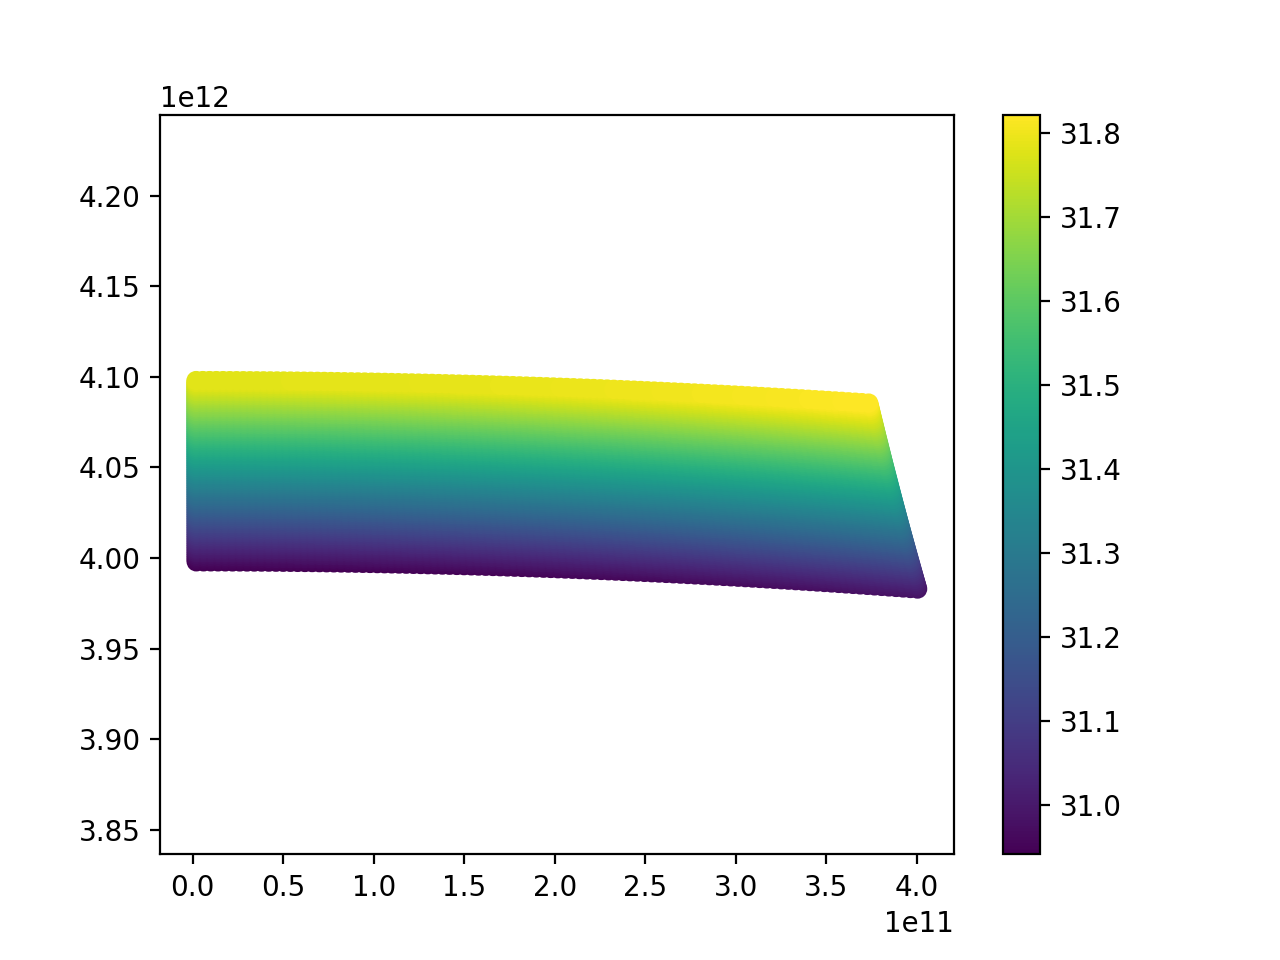

(-18058237051.822823, 420202220791.2503, 3977147124134.4697, 4103675562971.506)

In [21]:
fig = plt.figure()

ax = plt.gca()

mapp1 = ax.scatter(new_r[:,:,0],new_r[:,:,1], c = g[-1])

cb1 = plt.colorbar(mappable = mapp1, ax = ax)

plt.axis('equal')

# 4. Trying it all together

We now try to use this solver along with the scattering functions. We will use $100$ s and the same set of initial conditions.

We first decompose the position and velocity to have their x and y components. 

After this, we use omega_numpy to get a grid of unit vectors.

Then we retrieve the new radius grid (in x and y components) by scattering it for $100$ s. We use these components to calculate the magnitude of the radius vectors.

Then, we plug these matrices into the homologous outflow solver. 

In [22]:
start_numpy = time.time()

r_comps = np.zeros((r0_jet_axis.shape[0],r0_jet_axis.shape[1],2))

for i in range(r0_jet_axis.shape[0]):
    for j in range(r0_jet_axis.shape[0]):
        r_comps[i][j] = np.asarray([xv_jet_axis[i][j],yv_jet_axis[i][j]])

v_gamma = np.sqrt(1-1/gamma_jet_axis**2)*const.c.cgs.value

velo = np.zeros((gamma_jet_axis.shape[0],gamma_jet_axis.shape[1],2))

for i in range(gamma_jet_axis.shape[0]):
    for j in range(gamma_jet_axis.shape[0]):
        velo[i][j] = v_gamma[i][j]*np.asarray([xv_jet_axis[i][j],yv_jet_axis[i][j]])/r0_jet_axis[i][j]
        
vel_vecs = omega_numpy(velo)

new_r_100 = r_step_c_numpy(r_comps, s(10,100 + 10), omega_numpy(velo))

rf_jet_axis_100 = np.linalg.norm(new_r_100, axis = 2)

r_100, e_100, g_100, n_100, h_100 = homologous_outflow_numpy(
  gamma_jet_axis, 
  density_jet_axis, 
  r0_jet_axis, 
  rf_jet_axis_100, 
  h_i = h_i_jet_axis)

end_numpy = time.time()

print(end_numpy - start_numpy)

76.7870020866394


This is about twice as fast, taking 1.25 minutes (1:16) for it to calculate it. This also contains all the information for all steps in between the endpoints.

We now plot the new Lorentz factor.

<IPython.core.display.Javascript object>


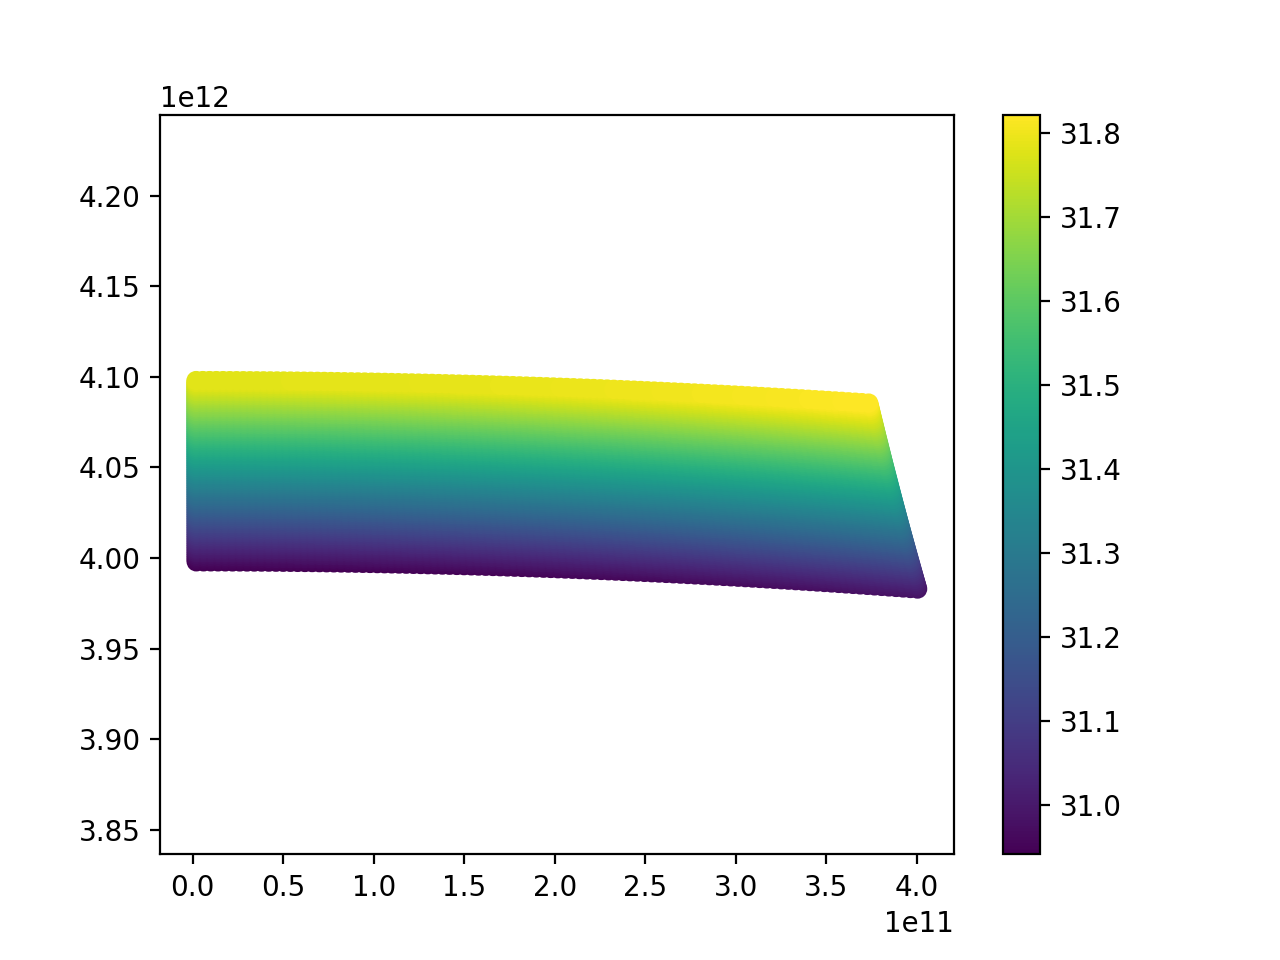

(-18058237051.822823, 420202220791.2503, 3977147124134.4697, 4103675562971.506)

In [24]:
fig = plt.figure()

ax = plt.gca()

mapp1 = ax.scatter(new_r_100[:,:,0],new_r_100[:,:,1], c = g_100[-1])

cb1 = plt.colorbar(mappable = mapp1, ax = ax)

plt.axis('equal')

There are two things I am trying to fully understand:

1. How can I adapt this to a large 1D vector for it to be easier to read in a HD frame?


2. How can I change the definition of the radius step size in the solver for it to be log instead of linear? This would make the function much faster, since the larger step sizes near the asymptotic behavior can save time without sacrificing too much numerical precision.